<a href="https://colab.research.google.com/github/YuriiKlim/Projects/blob/Clothing_Classifier/clothing_classifier_16k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from urllib.request import urlopen
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
import requests
from concurrent.futures import ThreadPoolExecutor
import random

import SegCloth
from SegCloth import segment_clothing

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'


device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
generator = torch.Generator(device='cuda')

torch.manual_seed(0)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [2]:
df = pd.read_csv('C:/Users/klimk/Desktop/Project/products_final.csv')
#df = pd.read_csv('C:/Users/klimk/Desktop/Nike/NikeOnly.csv')

In [3]:
df

,sku,Type,Color,Season,Gender,Brand
0,М990GL6,Sneakers,Grey,Demi-season,Male,New Balance
1,М2002RJX,Sneakers,Grey,Demi-season,Male,New Balance
2,ЕЕ5364,Sneakers,Black,Demi-season,Female,Adidas
3,ZXNCSMM1013-BLACK,Track-jacket,Black,Demi-season,Male,Castore
4,ZWFB8P557-ORS,Longsleeve,Black,Demi-season,Female,Nike
...,...,...,...,...,...,...
279891,"1,10E-42",Sneakers,Grey,Demi-season,Male,Brooks
279892,"1,10E-42",Sneakers,Black,Demi-season,Male,Brooks
279893,"1,10E-53",Sneakers,Black,Demi-season,Male,Brooks
279894,"1,10E-61",Sneakers,Grey,Demi-season,Male,Brooks


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279896 entries, 0 to 279895
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   sku     279896 non-null  object
 1   Type    279896 non-null  object
 2   Color   279896 non-null  object
 3   Season  279896 non-null  object
 4   Gender  279896 non-null  object
 5   Brand   279894 non-null  object
dtypes: object(6)
memory usage: 12.8+ MB


In [5]:
type_counts = df['Type'].value_counts()
type_counts

Type
Sneakers             78818
T-shirt              41997
Pants                21906
Shorts               18042
Hoodie               15596
Jacket               11747
Gumshoes              9999
Sweatshirt            8616
Longsleeve            6823
Slippers              5917
Sweater               5788
Tank-top              5171
Boots                 5050
Leggings              4184
Top                   3914
Polo                  3906
Football boots        3832
Track-jacket          3645
Full-zip Hoodie       3581
Shirt                 3574
Football sneakers     2004
Cap                   1987
Puffer jacket         1885
Sandals               1743
Backpack              1637
Shoes                 1504
Vest                  1464
Dress                 1292
Hat                    970
Skirt                  835
Bomber                 821
Parka                  746
High boot              510
Anorak                 392
Name: count, dtype: int64

In [6]:
type_counts = df['Color'].value_counts()
type_counts

Color
Black                  71932
White                  37981
Blue                   28215
Grey                   23429
Beige                  17411
                       ...  
Purple/Bordo               1
Bordo/Olive                1
Metallic/Light-Blue        1
Peach/Pink                 1
Red/Turquoise              1
Name: count, Length: 371, dtype: int64

In [7]:
img_size = 224
batch_size = 512

In [8]:
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
])

In [9]:
import cv2
from ultralytics import YOLO


class PhotoProcessing:
    def __init__(self, yolo_model_path='yolov8n.pt', data_dir='C:/Users/klimk/Desktop/Project/Main',
                 output_size=(800, 800), save_dir='C:/Users/klimk/Desktop/Nike/processed_all', device='cuda'):
        self.model = YOLO(yolo_model_path)
        self.data_dir = data_dir
        self.output_size = output_size
        self.save_dir = save_dir
        self.device = device
        self.model.to(self.device)
        self.processed_images = {}
        self.person_class_id = self._get_person_class_id()

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def _get_person_class_id(self):
        for class_id, class_name in self.model.names.items():
            if class_name == 'person':
                return class_id
        raise ValueError("Class 'person' not found in model classes")

    def load_image(self, file_name):
        file_path = os.path.join(self.data_dir, file_name + '.jpg')
        if os.path.exists(file_path):
            image = Image.open(file_path).convert("RGB")
            return image
        else:
            return None

    def resize_for_yolo(self, image):
        width, height = image.size
        new_width = (width // 32) * 32
        new_height = (height // 32) * 32
        resized_image = image.resize((new_width, new_height))
        return resized_image

    def process_image(self, image, sku):
        image_resized = self.resize_for_yolo(image)

        output_image_rgb = np.array(image_resized)
        output_image_tensor = torch.from_numpy(output_image_rgb).permute(2, 0, 1).float() / 255.0
        output_image_tensor = output_image_tensor.unsqueeze(0).to(self.device)

        results = self.model(output_image_tensor)

        detections = results[0].boxes.data.cpu().numpy()

        person_detected = any(int(detection[5]) == self.person_class_id for detection in detections)

        if person_detected:
            processed_image = self.apply_segcloth(image_resized)
        else:
            processed_image = self.apply_white_background(image_resized)

        processed_image = processed_image.resize(self.output_size)
        self.processed_images[sku] = processed_image

        self.save_image(processed_image, sku)

    def apply_segcloth(self, image):
        result = segment_clothing(img=image)
        return result

    def apply_white_background(self, image):
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        mask = np.zeros(image_cv.shape[:2], np.uint8)
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        rect = (10, 10, image_cv.shape[1] - 10, image_cv.shape[0] - 10)
        cv2.grabCut(image_cv, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        output_image = image_cv.copy()
        output_image[mask2 == 0] = [255, 255, 255]

        output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)
        return Image.fromarray(output_image_rgb)

    def save_image(self, image, sku):
        output_path = os.path.join(self.save_dir, f'{sku}.jpg')
        image.save(output_path)

    def process_images(self, skus):
        for sku in skus:
            image = self.load_image(sku)
            if image is not None:
                self.process_image(image, sku)

    def get_processed_images(self):
        return self.processed_images

In [10]:
def process_image_generator(skus, processor):
    processor.process_images(skus)
    processed_images = processor.get_processed_images()
    for sku in skus:
        if sku in processed_images:
            yield sku, processed_images[sku]

In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

processor = PhotoProcessing()

all_valid_skus = []

total_batches = len(df['sku']) // batch_size + 1

with ThreadPoolExecutor(max_workers=12) as executor:
    for i in tqdm(range(0, len(df['sku']), batch_size), desc="Processing Batches", total=total_batches):
        batch_skus = df['sku'][i:i + batch_size]

        results = list(executor.map(lambda skus: list(process_image_generator(skus, processor)), [batch_skus]))

        for result in results:
            for sku, image in result:
                all_valid_skus.append(sku)

df = df[df['sku'].isin(all_valid_skus)].reset_index(drop=True)

sku_count = df['sku'].count()
print(f"Total valid SKUs: {sku_count}")


Processing Batches:   0%|                                                                       | 0/32 [00:00<?, ?it/s]


0: 832x800 (no detections), 91.0ms
Speed: 0.0ms preprocess, 91.0ms inference, 9.8ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 1 scissors, 25.5ms
Speed: 0.0ms preprocess, 25.5ms inference, 42.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 1 skateboard, 63.5ms
Speed: 0.0ms preprocess, 63.5ms inference, 6.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 (no detections), 39.0ms
Speed: 0.0ms preprocess, 39.0ms inference, 3.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 (no detections), 81.1ms
Speed: 0.0ms preprocess, 81.1ms inference, 5.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 (no detections), 73.5ms
Speed: 0.0ms preprocess, 73.5ms inference, 5.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 1 tennis racket, 66.5ms
Speed: 0.0ms preprocess, 66.5ms inference, 13.0ms postprocess per image at shape (1, 3, 832, 800)

0: 832x800 1 surfboard, 1 banana, 53.0ms
Speed: 0.0ms preprocess, 53.0ms i

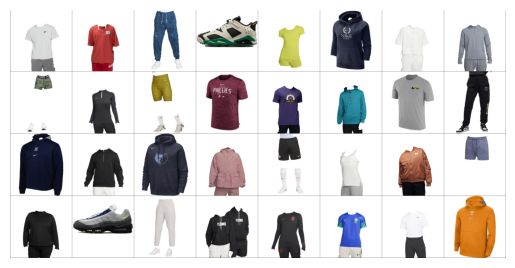

In [11]:
from torchvision.utils import make_grid

processed_images_dir = 'C:/Users/klimk/Desktop/Nike/processed'

processed_images_files = [os.path.join(processed_images_dir, f) for f in os.listdir(processed_images_dir) if f.endswith('.jpg')]

random_images_files = random.sample(processed_images_files, 32)

transform = transforms.ToTensor()
selected_images = [transform(Image.open(image_file).convert("RGB")) for image_file in random_images_files]

batch = torch.stack(selected_images)

grid = make_grid(batch).permute(1, 2, 0)

plt.imshow(grid)
plt.axis('off')
plt.show()

In [42]:
df = pd.read_csv('C:/Users/klimk/Desktop/Nike/NikeOnly.csv')
type_counts = df['Type'].value_counts()
type_counts

Type
T-shirt              3063
Sneakers             2241
Shorts               1730
Hoodie               1430
Pants                1425
Longsleeve           1309
Tank Top              987
Jacket                604
Sweatshirt            503
Sweater               472
Leggings              462
Polo                  419
Top                   345
Football Boots        298
Track Jacket          189
Full-zip Hoodie       187
Shirt                 119
Slippers              116
Football Sneakers      91
Skirt                  89
Vest                   87
Dress                  73
Puffer jacket          38
Parka                  37
Name: count, dtype: int64

In [41]:
data_dir = 'C:/Users/klimk/Desktop/Nike/processed'

def load_image(file_name):
    file_path = os.path.join(data_dir, file_name + '.jpg')
    if os.path.exists(file_path):
        image = Image.open(file_path)
        return image
    else:
        return None

In [24]:
def filter_df_by_images(df):
    valid_skus = []
    for sku in df['sku']:
        if load_image(sku) is not None:
            valid_skus.append(sku)
    return df[df['sku'].isin(valid_skus)].reset_index(drop=True)

df = filter_df_by_images(df)

print(f"New dataframe size: {len(df)}")

New dataframe size: 16230


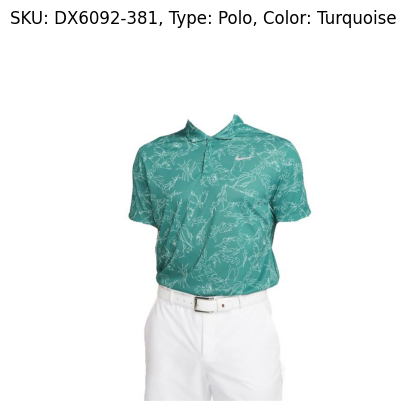

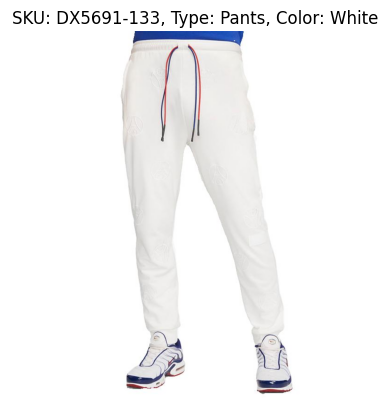

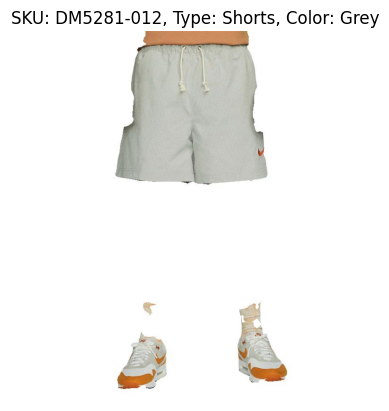

In [25]:
processed_images_files = [f for f in os.listdir(processed_images_dir) if f.endswith('.jpg')]

random_skus = random.sample(processed_images_files, 3)

for sku in random_skus:
    img_path = os.path.join(processed_images_dir, sku)
    img = Image.open(img_path).convert("RGB")

    sku_name = os.path.splitext(sku)[0]

    sku_row = df[df['sku'] == sku_name]
    if not sku_row.empty:
        label_name = sku_row['Type'].values[0]
        color_name = sku_row['Color'].values[0]

        plt.imshow(img)
        plt.title(f"SKU: {sku_name}, Type: {label_name}, Color: {color_name}")
        plt.axis('off')
        plt.show()
    else:
        print(f"SKU {sku_name} не знайдено в датафреймі.")

In [43]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

df['Type'] = label_encoder.fit_transform(df['Type'])

type_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

type_mapping

{'Dress': 0,
 'Football Boots': 1,
 'Football Sneakers': 2,
 'Full-zip Hoodie': 3,
 'Hoodie': 4,
 'Jacket': 5,
 'Leggings': 6,
 'Longsleeve': 7,
 'Pants': 8,
 'Parka': 9,
 'Polo': 10,
 'Puffer jacket': 11,
 'Shirt': 12,
 'Shorts': 13,
 'Skirt': 14,
 'Slippers': 15,
 'Sneakers': 16,
 'Sweater': 17,
 'Sweatshirt': 18,
 'T-shirt': 19,
 'Tank Top': 20,
 'Top': 21,
 'Track Jacket': 22,
 'Vest': 23}

In [44]:
len(type_mapping)

24

In [27]:
from sklearn.model_selection import train_test_split

train_ratio = 0.8

grouped = df.groupby('Type')

train_list = []
val_list = []

for _, group in grouped:
    train, val = train_test_split(group, test_size=1 - train_ratio, random_state=42)
    train_list.append(train)
    val_list.append(val)

train_data = pd.concat(train_list).reset_index(drop=True)
val_data = pd.concat(val_list).reset_index(drop=True)

print(f"Train data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

Train data size: 12972
Validation data size: 3258


In [28]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from tqdm import tqdm
import os

train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize(mean=[0.8329, 0.8211, 0.8254], std=[0.2497, 0.2639, 0.2580])
])

test_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8329, 0.8211, 0.8254], std=[0.2497, 0.2639, 0.2580])
])


class TransformDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if idx >= len(self.dataframe):
            raise IndexError(f"Index {idx} extends beyond the DataFrame")

        try:
            row = self.dataframe.iloc[idx:idx+1].squeeze()
        except KeyError as e:
            raise KeyError(f"Index access error {idx} in DataFrame: {e}")

        sku = row['sku']
        img_path = os.path.join(self.data_dir, f"{sku}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = row['Type']
        label = torch.tensor(label, dtype=torch.long)
        return image, label


train_dataset = TransformDataset(train_data, data_dir=data_dir, transform=train_transform)
val_dataset = TransformDataset(val_data, data_dir=data_dir, transform=test_transform)

print(f"Train Dataset size: {len(train_dataset)}")
print(f"Validation Dataset size: {len(val_dataset)}")

Train Dataset size: 12972
Validation Dataset size: 3258


In [29]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, generator=generator)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, generator=generator)

In [ ]:
# means = []
# stds = []

# print("Calculation of mean values ​​and standard deviations for normalization:")
# for idx, (img, _) in enumerate(tqdm(val_dataset, desc="Calculating mean/std")):
#     if img.shape[0] == 3:
#         means.append(torch.mean(img, dim=[1, 2]).tolist())
#         stds.append(torch.std(img, dim=[1, 2]).tolist())
#     else:
#         filename = val_data.iloc[idx]['sku']
#         print(f"The image {filename} has an incorrect number of channels: {img.shape[0]}")

# mean = torch.mean(torch.tensor(means), dim=0)
# std = torch.mean(torch.tensor(stds), dim=0)

# mean, std

In [30]:
from torchvision import models

resnet152 = models.resnet152(pretrained=True)
resnet152

C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\klimk\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
class TransferLearningClassifier(nn.Module):
    def __init__(self, num_classes=24):
        super().__init__()

        resnet = models.resnet152(pretrained=True)

        for param in resnet.parameters():
            param.requires_grad = False

        in_features = resnet.fc.in_features

        resnet.fc = nn.Identity()

        self.feature_extractor = resnet

        self.fc1 = nn.Linear(in_features, 512)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(256, num_classes)

    def forward(self, x):
        out = self.feature_extractor(x)
        if isinstance(out, tuple):
            out = out[0]

        out = F.relu(self.fc1(out))
        out = self.dropout1(out)
        out = F.relu(self.fc2(out))
        out = self.dropout2(out)
        out = self.fc3(out)
        return out

    def predict(self, data_loader, device='cpu'):
        self.eval()
        all_preds = []

        with torch.no_grad():
            for inputs in data_loader:
                inputs = inputs.to(device)
                outputs = self(inputs)
                preds = F.softmax(outputs, dim=-1)
                all_preds.append(preds.cpu().numpy())

        return np.concatenate(all_preds, axis=0)

model = TransferLearningClassifier(num_classes=len(train_data['Type'].unique())).to(device)

In [32]:
from torchsummary import summary

summary(model, input_size=(3, img_size, img_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [33]:
class_counts = df['Type'].value_counts()

total_samples = len(df)

class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

weights = torch.tensor([class_weights[cls] for cls in sorted(class_counts.index)], dtype=torch.float32).to(device)

weights

tensor([222.3288,  54.6465, 178.3517,  86.7914,  11.3576,  26.8709,  35.2061,  12.4178,  11.4055, 438.6487,  38.7351, 427.1053, 143.6283,   9.4032, 182.3596, 146.2162,   7.2944,  34.3856,  32.3952,   5.3109,  16.5275,  51.8530,  85.8730, 186.5517], device='cuda:0')

In [34]:
loss_fn = nn.CrossEntropyLoss(weight=weights)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [35]:
import time

def train(model, optimizer, loss_fn, train_dl, val_dl, scheduler=None,
          metrics=None, metrics_name=None, epochs=20, device=device, task='regression', log_interval=1):
    metrics = metrics if metrics else []
    metrics_name = metrics_name if metrics_name else [metric.__name__ for metric in metrics]

    history = {}
    history['loss'] = []
    history['val_loss'] = []
    for name in metrics_name:
        history[name] = []
        history[f'val_{name}'] = []

    model.to(device)

    start_time_train = time.time()

    for epoch in range(epochs):
        start_time_epoch = time.time()

        model.train()
        history_train = {name: 0 for name in ['loss'] + metrics_name}

        for batch in train_dl:
            x = batch[0].to(device)
            y = batch[1].to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred = y_pred.detach().cpu().numpy()
            y = y.detach().cpu().numpy()

            history_train['loss'] += loss.item() * x.size(0)
            for name, func in zip(metrics_name, metrics):
                try:
                    if func == roc_auc_score:
                        # Check if there are both classes present in y
                        if len(np.unique(y)) == 2:
                            history_train[name] += func(y, y_pred) * x.size(0)
                    else:
                        history_train[name] += func(y, y_pred) * x.size(0)
                except:
                    if task == 'binary':
                        y_pred_ = y_pred.round()
                    elif task == 'multiclass':
                        y_pred_ = y_pred.argmax(axis=-1)
                    history_train[name] += func(y, y_pred_) * x.size(0)

        for name in history_train:
            history_train[name] /= len(train_dl.dataset)

        model.eval()
        history_val = {'val_' + name: 0 for name in metrics_name + ['loss']}

        with torch.no_grad():
            for batch in val_dl:
                x = batch[0].to(device)
                y = batch[1].to(device)
                y_pred = model(x)
                loss = loss_fn(y_pred, y)

                y_pred = y_pred.cpu().numpy()
                y = y.cpu().numpy()

                history_val['val_loss'] += loss.item() * x.size(0)
                for name, func in zip(metrics_name, metrics):
                    try:
                        if func == roc_auc_score:
                            # Check if there are both classes present in y
                            if len(np.unique(y)) == 2:
                                history_val['val_' + name] += func(y, y_pred) * x.size(0)
                        else:
                            history_val['val_' + name] += func(y, y_pred) * x.size(0)
                    except:
                        if task == 'binary':
                            y_pred_ = y_pred.round()
                        elif task == 'multiclass':
                            y_pred_ = y_pred.argmax(axis=-1)

                        history_val['val_' + name] += func(y, y_pred_) * x.size(0)

        for name in history_val:
            history_val[name] /= len(val_dl.dataset)

        end_time_epoch = time.time()

        for name in history_train:
            history[name].append(history_train[name])
            history['val_' + name].append(history_val['val_' + name])

        total_time_epoch = end_time_epoch - start_time_epoch

        if epoch + 1 == 1 or (epoch + 1) % log_interval == 0 or epoch + 1 == epochs:
            print(f'Epoch {epoch + 1:4d} {total_time_epoch:4.0f}sec', end='\t')
            for name in history_train:
                print(f'{name}: {history[name][-1]:10.3g}', end='\t')
                print(f"val_{name}: {history['val_' + name][-1]:10.3g}", end='\t')
            print()

        if scheduler:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(history_val['val_loss'][-1])
            else:
                scheduler.step()

    end_time_train = time.time()
    total_time_train = end_time_train - start_time_train
    print()
    print('Time total:     %5.2f sec' % (total_time_train))

    return history

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score

history = train(model, optimizer, loss_fn, train_loader, val_loader,
                epochs=40,
                metrics=[accuracy_score],
                device=device,
                task='multiclass',
               log_interval=2)

In [ ]:
import matplotlib.pyplot as plt

def plot_metric(history, name):
    plt.title(f"Model results with {name}")
    plt.plot(history[name], label='train')
    plt.plot(history['val_'+name], label='val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()


plot_metric(history, 'loss')

In [ ]:
plot_metric(history, 'accuracy_score')

In [ ]:
inverse_type_mapping = {v: k for k, v in type_mapping.items()}

model = model.to('cpu')
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for X, y in val_loader:
        y_true.extend(y.cpu().numpy())
        X = X.to('cpu')
        y_pred_ = model(X)
        y_pred_ = y_pred_.argmax(-1).cpu().numpy()
        y_pred.extend(y_pred_)

y_true_text = [inverse_type_mapping[label] for label in y_true]
y_pred_text = [inverse_type_mapping[label] for label in y_pred]

class_labels = [inverse_type_mapping[i] for i in sorted(inverse_type_mapping.keys())]

fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_predictions(y_true_text, y_pred_text, display_labels=class_labels, ax=ax)
plt.xticks(rotation=90)
plt.show()

In [ ]:
model_save_path = 'C:/Users/klimk/Desktop/Nike/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

In [51]:
class PhotoProcessing1:
    def __init__(self, yolo_model_path='yolov8n.pt', data_dir='D:/Main',
                 output_size=(800, 800), save_dir='C:/Users/klimk/Desktop/Nike/processed_all',
                 background_color='white', save_format='jpg', device='cuda'):
        self.model = YOLO(yolo_model_path)
        self.data_dir = data_dir
        self.output_size = output_size
        self.save_dir = save_dir
        self.device = device
        self.background_color = background_color.lower()
        self.save_format = save_format.lower()
        self.model.to(self.device)
        self.processed_images = {}
        self.person_class_id = self._get_person_class_id()

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)

    def _get_person_class_id(self):
        for class_id, class_name in self.model.names.items():
            if class_name == 'person':
                return class_id
        raise ValueError("Class 'person' not found in model classes")

    def load_image(self, file_name):
        file_path = os.path.join(self.data_dir, file_name + '.jpg')
        if os.path.exists(file_path):
            image = Image.open(file_path).convert("RGB")
            return image
        else:
            return None

    def resize_for_yolo(self, image):
        width, height = image.size
        new_width = (width // 32) * 32
        new_height = (height // 32) * 32
        resized_image = image.resize((new_width, new_height))
        return resized_image

    def process_image(self, image, sku):
        image_resized = self.resize_for_yolo(image)

        output_image_rgb = np.array(image_resized)
        output_image_tensor = torch.from_numpy(output_image_rgb).permute(2, 0, 1).float() / 255.0
        output_image_tensor = output_image_tensor.unsqueeze(0).to(self.device)

        results = self.model(output_image_tensor)

        detections = results[0].boxes.data.cpu().numpy()

        person_detected = any(int(detection[5]) == self.person_class_id for detection in detections)

        if person_detected:
            processed_image = self.apply_segcloth(image_resized)
        else:
            processed_image = self.apply_background_color(image_resized)

        processed_image = processed_image.resize(self.output_size)
        self.processed_images[sku] = processed_image

        self.save_image(processed_image, sku)

    def apply_segcloth(self, image):
        result = segment_clothing(img=image)
        return result

    def apply_background_color(self, image):
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        mask = np.zeros(image_cv.shape[:2], np.uint8)
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        rect = (10, 10, image_cv.shape[1] - 10, image_cv.shape[0] - 10)
        cv2.grabCut(image_cv, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        output_image = image_cv.copy()

        if self.background_color == 'white':
            output_image[mask2 == 0] = [255, 255, 255]
        elif self.background_color == 'black':
            output_image[mask2 == 0] = [0, 0, 0]
        elif self.background_color == 'transparent':
            output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2BGRA)
            output_image[mask2 == 0] = [0, 0, 0, 0]
        else:
            raise ValueError("Unsupported background color")

        output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB if self.background_color != 'transparent' else cv2.COLOR_BGRA2RGBA)
        return Image.fromarray(output_image_rgb)

    def save_image(self, image, sku):
        output_path = os.path.join(self.save_dir, f'{sku}.{self.save_format}')
        image.save(output_path, format=self.save_format.upper())

    def process_images(self, skus):
        for sku in skus:
            image = self.load_image(sku)
            if image is not None:
                self.process_image(image, sku)

    def get_processed_images(self):
        return self.processed_images

In [55]:
class PhotoProcessing1:
    def __init__(self, yolo_model_path='yolov8n.pt', data_dir='D:/Main',
                 output_size=(800, 800), background_color='white', device='cuda'):
        self.model = YOLO(yolo_model_path)
        self.data_dir = data_dir
        self.output_size = output_size
        self.device = device
        self.background_color = background_color.lower()
        self.model.to(self.device)
        self.processed_images = {}
        self.person_class_id = self._get_person_class_id()

    def _get_person_class_id(self):
        for class_id, class_name in self.model.names.items():
            if class_name == 'person':
                return class_id
        raise ValueError("Class 'person' not found in model classes")

    def load_image(self, file_name):
        file_path = os.path.join(self.data_dir, file_name + '.jpg')
        if os.path.exists(file_path):
            image = Image.open(file_path).convert("RGB")
            return image
        else:
            return None

    def resize_for_yolo(self, image):
        width, height = image.size
        new_width = (width // 32) * 32
        new_height = (height // 32) * 32
        resized_image = image.resize((new_width, new_height))
        return resized_image

    def process_image(self, image, sku):
        image_resized = self.resize_for_yolo(image)

        output_image_rgb = np.array(image_resized)
        output_image_tensor = torch.from_numpy(output_image_rgb).permute(2, 0, 1).float() / 255.0
        output_image_tensor = output_image_tensor.unsqueeze(0).to(self.device)

        results = self.model(output_image_tensor)

        detections = results[0].boxes.data.cpu().numpy()

        person_detected = any(int(detection[5]) == self.person_class_id for detection in detections)

        if person_detected:
            processed_image = self.apply_segcloth(image_resized)
        else:
            processed_image = self.apply_background_color(image_resized)

        processed_image = processed_image.resize(self.output_size)
        self.processed_images[sku] = processed_image

    def apply_segcloth(self, image):
        result = segment_clothing(img=image)
        return result

    def apply_background_color(self, image):
        image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

        mask = np.zeros(image_cv.shape[:2], np.uint8)
        bgdModel = np.zeros((1, 65), np.float64)
        fgdModel = np.zeros((1, 65), np.float64)
        rect = (10, 10, image_cv.shape[1] - 10, image_cv.shape[0] - 10)
        cv2.grabCut(image_cv, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

        mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
        output_image = image_cv.copy()

        if self.background_color == 'white':
            output_image[mask2 == 0] = [255, 255, 255]
        elif self.background_color == 'black':
            output_image[mask2 == 0] = [0, 0, 0]
        elif self.background_color == 'transparent':
            output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2BGRA)
            output_image[mask2 == 0] = [0, 0, 0, 0]
        else:
            raise ValueError("Unsupported background color")

        output_image_rgb = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB if self.background_color != 'transparent' else cv2.COLOR_BGRA2RGBA)
        return Image.fromarray(output_image_rgb)

    def process_images(self, skus):
        for sku in skus:
            image = self.load_image(sku)
            if image is not None:
                self.process_image(image, sku)

    def get_processed_images(self):
        return self.processed_images

Model loaded from C:/Users/klimk/Desktop/Nike/model.pth


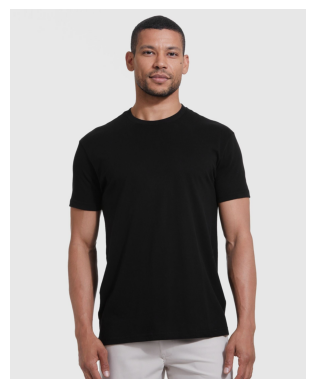


0: 2176x1760 8 persons, 210.2ms
Speed: 0.0ms preprocess, 210.2ms inference, 5.0ms postprocess per image at shape (1, 3, 2176, 1760)
Predicted class: T-shirt


In [57]:
import requests
from io import BytesIO

model_load_path = 'C:/Users/klimk/Desktop/Nike/model.pth'
loaded_model = TransferLearningClassifier(num_classes=len(label_encoder.classes_))
loaded_model.load_state_dict(torch.load(model_load_path))
loaded_model.eval()

print(f"Model loaded from {model_load_path}")

def load_and_predict(url, model, processor, transform, device='cpu'):
    response = requests.get(url)
    image = Image.open(BytesIO(response.content)).convert('RGB')

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    processor.process_image(image, sku="temp_sku")
    processed_image = processor.get_processed_images()["temp_sku"]

    image_tensor = transform(processed_image).unsqueeze(0)

    model = model.to(device)
    image_tensor = image_tensor.to(device)
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        prediction = output.argmax(dim=1).item()

    class_name = label_encoder.inverse_transform([prediction])[0]

    return class_name

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.8329, 0.8211, 0.8254], std=[0.2497, 0.2639, 0.2580])
])

processor = PhotoProcessing1(background_color='white')

url = 'https://www.trueclassictees.com/cdn/shop/files/4000_BLACK_2.jpg?v=1710264591'
predicted_class = load_and_predict(url, loaded_model, processor, transform, device=device)
print(f"Predicted class: {predicted_class}")


0: 2176x1760 8 persons, 238.2ms
Speed: 0.0ms preprocess, 238.2ms inference, 8.0ms postprocess per image at shape (1, 3, 2176, 1760)


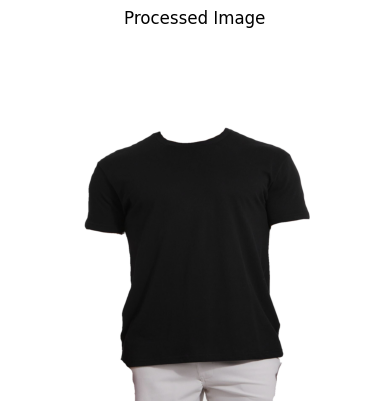

Colors:
Black: 86.13%


In [39]:
from collections import Counter

class ColorAnalyzerHSV:
    def __init__(self):
        self.colors_ranges = {
            "Beige": ([20, 50, 100], [30, 150, 200]),
            "Black": ([0, 0, 0], [180, 255, 50]),
            "Blue": ([100, 150, 0], [140, 255, 255]),
            "Bordo": ([160, 100, 20], [180, 255, 255]),
            "Brown": ([10, 100, 20], [20, 255, 200]),
            "Green": ([35, 100, 20], [85, 255, 255]),
            "Grey": ([0, 0, 50], [180, 50, 200]),
            "Light-Blue": ([90, 50, 70], [110, 255, 255]),
            "Olive": ([25, 50, 50], [45, 255, 200]),
            "Orange": ([5, 100, 100], [15, 255, 255]),
            "Pink": ([140, 100, 100], [170, 255, 255]),
            "Red": ([0, 100, 100], [10, 255, 255]),
            "Turquoise": ([85, 100, 100], [100, 255, 255]),
            "Purple": ([130, 50, 50], [160, 255, 255]),
            "White": ([0, 0, 200], [180, 30, 255]),
            "Yellow": ([20, 100, 100], [30, 255, 255])
        }

    def find_dominant_colors(self, image, mask, min_area_threshold=0.15):
        image = np.array(image)
        image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        color_areas = {}

        for color_name, (lower, upper) in self.colors_ranges.items():
            lower_bound = np.array(lower, dtype="uint8")
            upper_bound = np.array(upper, dtype="uint8")

            mask_color = cv2.inRange(image_hsv, lower_bound, upper_bound)
            combined_mask = cv2.bitwise_and(mask_color, mask)
            color_area = cv2.countNonZero(combined_mask)
            total_area = cv2.countNonZero(mask)

            area_percentage = color_area / total_area

            if area_percentage > min_area_threshold:
                color_areas[color_name] = area_percentage * 100

        return color_areas

def load_image_from_url(url):
    response = requests.get(url)
    if response.status_code == 200:
        image = Image.open(BytesIO(response.content)).convert("RGB")
        return image
    else:
        print(f"Не вдалося завантажити зображення. Код статусу: {response.status_code}")
        return None

def main():
    processor = PhotoProcessing1(background_color='white', save_format='png')

    image_url = "https://www.trueclassictees.com/cdn/shop/files/4000_BLACK_2.jpg?v=1710264591"
    image = load_image_from_url(image_url)

    if image is None:
        print("Не вдалося завантажити зображення з URL.")
        return

    processor.process_image(image, sku="processed_image")
    processed_image = processor.get_processed_images().get("processed_image")

    if processed_image is None:
        print("Оброблене зображення не знайдено.")
        return

    plt.imshow(processed_image)
    plt.axis('off')
    plt.title("Processed Image")
    plt.show()

    image_np = np.array(processed_image)
    mask = np.zeros(image_np.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (10, 10, image_np.shape[1] - 10, image_np.shape[0] - 10)
    cv2.grabCut(image_np, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)

    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

    analyzer = ColorAnalyzerHSV()
    dominant_colors = analyzer.find_dominant_colors(processed_image.convert("RGB"), mask2)

    if dominant_colors:
        print("Colors:")
        for color_name, percentage in dominant_colors.items():
            print(f"{color_name}: {percentage:.2f}%")
    else:
        print("No dominant colors found above the threshold.")

if __name__ == "__main__":
    main()